In [1]:
import autogen
import json
import os
from sentence_transformers import SentenceTransformer
import numpy as np
from collections import defaultdict
import statistics
import matplotlib.pyplot as plt
import copy
import random
from scipy import stats
import math

# Parameters (Needs to be configured to the specific task)

In [2]:
def read_task_output_file(file_name):
    """
    Read the task output logs
    
    Args:
    - file_name (str): The single log file that wants to get evaluated.
    """
    with open(file_name) as file:
        output = json.load(file)
    return json.dumps(output, indent=1)

In [3]:
task={'name': 'alfworld',
      'description': "Perform actions and interact with a household to solve a task. At the beginning of your interactions, you will be given the detailed description of the current environment and your goal to accomplish. For each of your turn, you should choose from two actions: \"THOUGHT\" or \"ACTION\". If you choose \"THOUGHT\", you should first think about the current condition and plan for your future actions, and then output your action in this turn. Your output must strictly follow this format:\"THOUGHT: your thoughts.\n\" \"ACTION: your next action\n\"; If you choose \"ACTION\", you should directly output the action in this turn. Your output must strictly follow this format:\"ACTION: your next action\n\". After each of your turn, the environment will give you immediate feedback based on which you should plan your next few steps. if the envrionment output \"Nothing happened\", that means the previous action is invalid and you should try more options.\n Reminder: \n1. the action must be chosen from the given available actions. Any actions except provided available actions will be regarded as illegal.\n2. Take the target household immediatly after you find it.\n3. Reply 'TERMINATE' only under two circumstances: a). The task has given you clear instructions to return 'TERMINATE' b). The task seems insolvable.\n Here are two examples.",
      'example_task':"""
      "You are in the middle of a room. Looking quickly around you, you see a cabinet 16, a cabinet 15, a cabinet 14, a cabinet 13, a cabinet 12, a cabinet 11, a cabinet 10, a cabinet 9, a cabinet 8, a cabinet 7, a cabinet 6, a cabinet 5, a cabinet 4, a cabinet 3, a cabinet 2, a cabinet 1, a coffeemachine 1, a countertop 2, a countertop 1, a diningtable 1, a drawer 5, a drawer 4, a drawer 3, a drawer 2, a drawer 1, a fridge 1, a garbagecan 1, a microwave 1, a safe 1, a sinkbasin 1, a stoveburner 4, a stoveburner 3, a stoveburner 2, a stoveburner 1, and a toaster 1.\nYour task is to: cool some pan and put it in stoveburner.\n",
      "THOUGHT: The task is to cool some pan and put it in stoveburner, so i need to first find a pan and cool it. First I need to find a pan. An pan is more likely to appear in stoveburner (1-4), sinkbasin (1), diningtable (1), countertop (1-2), cabinet (1-16), drawer (1-5). I can check one by one, starting with stoveburner 1.\n ACTION: go to stoveburner 1\n",
      "On the stoveburner 1, you see nothing.\n",
      "ACTION: go to stoveburner 2\n",
      "On the stoveburner 2, you see a pot 1.\n",
      "ACTION: go to stoveburner 3\n",
      "On the stoveburner 3, you see a pan 1.\n",
      "ACTION: take pan 1 from stoveburner 3\n",
      "You pick up the pan 1 from the stoveburner 3.\n",
      "THOUGHT: Now i have taken the pan 1 with me and i want to cool it using a fridge.\n ACTION: go to fridge 1\n",
      "The fridge 1 is closed.\n",
      "ACTION: cool pan 1 with fridge 1\n",
      "You cool the pan 1 using the fridge 1.\n",
      "THOUGHT: Now that i have a cooled pan, i need to go to a stoveburner and put it on the stoveburner.\n ACTION: go to stoveburner 1\n",
      "On the stoveburner 1, you see nothing.\n",
      "ACTION: put pan 1 in/on stoveburner 1\n",
      "You put the pan 1 in/on the stoveburner 1.\nTask success, now reply TERMINATE\n",
      "TERMINATE",
      "TERMINATE"
      """}


sys_msg=f"""Task: {task['name']}.
Task description: {task['description']}
Task example: {task['example_task']}
"""

In [4]:
# parameters, input path and output path
num_critic_seeds = 50
num_quantifier_seeds = 18
critic_agent_output_path_prefix = '../../draft_plots/alfworld/criteria/Alfworld_c-'
final_summarized_criteria_output_path = "final_filtered_criteria.json"
task_logs_input_path = "../data/multiagent"
quantifier_agent_all_at_once_output_path_prefix = "quantified_output-"
quantifie_coef_var_plot_output_path = "mean_coeff_var_comparison.png"
root_path = "../data"
agents = ['multiagent', 'twoagent']
original_examples_output_path = "original_examples.json"
adversarial_examples_output_path = "adversarial_examples.json"
adversarial_testing_evaluated_results_output_path = "adversarial_testing_evaluated_results-"
quantifier_adversarial_testing_plot_output_path = "adversarial_quantifier_performance.png"

In [5]:
# load the original logs (directory might be structured differently)
original_test_cases = {}

for prefix in os.listdir(task_logs_input_path):
    if prefix == '.DS_Store':
        continue
    for file_name in os.listdir(task_logs_input_path+"/"+prefix):
        gameid = prefix+"_"+file_name
        
        if file_name.split('.')[-1]=='json':
            test_case = read_task_output_file(task_logs_input_path+"/"+prefix+'/'+file_name)
            original_test_cases[gameid] = test_case

In [6]:
# Which part of the task output to drop might be different
def create_adversarial_samples(text):
    original_sample = json.loads(text)
    adversarial_sample = []
    
    for m in original_sample: 
        if m['role'] == 'assistant':
            original_content = m['content']
            original_content_list = list(filter(lambda x: len(x) > 0, original_content.split(' ')))                
            frac = 0.5 
            inds = set(random.sample(list(range(len(original_content_list))), int(frac*len(original_content_list))))
            new_content_list = [n for i,n in enumerate(original_content_list) if i not in inds]
            new_content = ' '.join(new_content_list)
            adversarial_sample.append({'content': new_content, 'role': 'assistant'})
        else:
            adversarial_sample.append(m)
    
    return json.dumps(adversarial_sample, indent=2)

In [7]:
# LLM API
config_list = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
)

%env AUTOGEN_USE_DOCKER=0

env: AUTOGEN_USE_DOCKER=0


# Checkpoint 1: Run CriticAgent Multiple Times

In [ ]:
for i in range(num_critic_seeds):
        
    critic = autogen.AssistantAgent(
        name = "critic",
        llm_config = {"config_list": config_list,"cache_seed":i},
        system_message = """You are a helpful assistant. You suggest criteria for evaluating different tasks. They should be dinstinguishable, quantifieable and not redundant.
        Convert the evaluation criteria into a dictionary where the keys are the criteria.
        The value of each key is a dictionary as follows {"description": criteria description , "accepted_values": possible accepted inputs for this key}
        Make sure the keys are criteria for assessing the given task.  "accepted_values" include the acceptable inputs for each key that are fine-grained and preferrably mlti-graded levels. "description" includes the criterion description.
        Return the dictionary."""
    )

    critic_user = autogen.UserProxyAgent(
        name = "critic_user",
        max_consecutive_auto_reply = 0,  # terminate without auto-reply
        human_input_mode = "NEVER",
    )

    gen_criteria = critic_user.initiate_chat(critic, message=sys_msg)
    criteria = critic_user.last_message()
    with open(critic_agent_output_path_prefix + str(i) + ".json", "w") as cr_file:
        crit_dict = json.loads(criteria["content"])
        json.dump(crit_dict,cr_file,indent=2)

# Checkpoint 2: Generate Summarized Criteria

In [ ]:
# load data
crit_dicts = []

for i in range(num_critic_seeds):
    with open(critic_agent_output_path_prefix + str(i) + ".json",'r') as fptr:
        criteria = json.load(fptr)
        crit_dicts.append(criteria)

In [ ]:
criteria_summarizer_message_base = """You are a helpful assistant. You suggest criteria for evaluating different tasks. They should be dinstinguishable, quantifieable and not redundant.
A criteria dictionary is a dictionary where the keys are the criteria. 
The value of each key is a dictionary as follows {"description": criteria description , "accepted_values": possible accepted inputs for this key}
You will be given a list of criteria dictionaries that others have suggested. They will be of varying qualities, and some of them will be synonymous.
You should pick the best 25 distinct criteria for the task, and each criterion's corresponding best decription and range of accepted values.
Your output should be a criteria dictionary containing the 25 distinct criteria you have picked.
Make sure the keys are criteria for assessing the given task.  "accepted_values" include the acceptable inputs for each key that are fine-grained and preferrably mlti-graded levels. "description" includes the criterion description.
Return only the dictionary, and in json format."""

criteria_summarizer = autogen.AssistantAgent(
    name = "criteria_summarizer",
    llm_config = {"config_list": config_list},
    system_message = criteria_summarizer_message_base,
)

In [ ]:
def get_summarized_criteria(crit_dicts):
    criteria_summarizer_user = autogen.UserProxyAgent(
        name = "criteria_summarizer_user",
        max_consecutive_auto_reply = 0,  # terminate without auto-reply
        human_input_mode = "NEVER",
    )    

    message = f"""Task: {task["name"]}.
Task description: {task["description"]}
Suggested criteria: {crit_dict}
"""

    criteria_summarizer_user.initiate_chat(criteria_summarizer, message=message)
    # return the last received from the criteria summarizer
    return criteria_summarizer_user.last_message()["content"]

In [ ]:
summarized_criteria_list = []

for i in range(len(crit_dicts) // 25):
    summarized_criteria_list.append(get_summarized_criteria(crit_dicts[i*25 : (i+1)*25]))

final_summarized_criteria = get_summarized_criteria(summarized_criteria_list)

In [ ]:
final_summarized_criteria = json.loads(final_summarized_criteria)

# convert to a list of words
conversion_dict_final = {}
for criteria in final_summarized_criteria:
    conversion_dict_final[' '.join(criteria.lower().split('_'))] = criteria

final_list_of_criteria = list(conversion_dict_final.keys())

In [ ]:
# set up synonymous detection
def find_synonymous_in_list(word_list, threshold=0.75):
    model = SentenceTransformer('paraphrase-MiniLM-L6-v2')  # Load a pre-trained SentenceTransformer model
    embeddings = model.encode(word_list, convert_to_tensor=True)  # Compute embeddings for the word list

    processed_words = set()
    used_in_synonyms = set()
    synonymous_dict = {}

    for i, word in enumerate(word_list):
        if word not in processed_words and word not in used_in_synonyms:
            synonymous_list = []
            for j, other_word in enumerate(word_list):
                if i != j:
                    cosine_sim = np.dot(embeddings[i], embeddings[j]) / (np.linalg.norm(embeddings[i]) * np.linalg.norm(embeddings[j]))
                    if cosine_sim > threshold:
                        synonymous_list.append(other_word)
                        used_in_synonyms.add(other_word)
            if synonymous_list or word not in synonymous_dict:  # Check if synonymous_list is not empty or word is not already added
                synonymous_list = list(set(synonymous_list))  # Remove duplicates from the list
                synonymous_list.sort()  # Sort the list to make the output consistent
                synonymous_dict[word] = synonymous_list
            processed_words.add(word)
    
    return synonymous_dict

In [ ]:
synonymous_dict = find_synonymous_in_list(final_list_of_criteria)
final_criteria = {}
for criteria in synonymous_dict:
    final_criteria[criteria] = final_summarized_criteria[conversion_dict_final[criteria]]

In [ ]:
with open(final_summarized_criteria_output_path, "w") as outfile:
    json.dump(final_criteria, outfile, indent = 4)

# Checkpoint 3: Run QuantifierAgent

In [8]:
# load the criteria
with open(final_summarized_criteria_output_path) as crit_file:
    criteria = json.load(crit_file)

In [9]:
crit = list(criteria.items())
crits = [dict(crit[:len(crit)//2]), dict(crit[len(crit)//2:])]

In [ ]:
def run_quantifier_agent_all_criteria_at_once(num_seeds):
    quantifier_message_base = """You are a helpful assistant. You quantify the output of different tasks based on the given criteria.
    The criterion is given in a dictionary format where each key is a dintinct criteria.
    The value of each key is a dictionary as follows {"description": criteria description , "accepted_values": possible accepted inputs for this key}
    You are going to quantify each of the crieria for a given task based on the task decription.
    Return a dictionary where the keys are the criteria and the values are the assessed performance based on accepted values for each criteria.
    Return only the dictionary as a json format string and nothing else."""

    for seed in range(num_seeds):
        outcome = {}
        quantifier = autogen.AssistantAgent(
            name = "quantifier",
            llm_config = {"config_list": config_list,"cache_seed":seed},
            system_message = quantifier_message_base)

        for gameid in original_test_cases:
            test_case = original_test_cases[gameid]

            try:
    
                original_result = {}
    
                for crit_dict in crits:
                    quantifier_user = autogen.UserProxyAgent(
                        name = "quantifier_user",
                        max_consecutive_auto_reply = 0,  # terminate without auto-reply
                        human_input_mode = "NEVER",
                    )
                    cq_results = quantifier_user.initiate_chat(quantifier, message = sys_msg + \
                                                    "Evaluation dictionary: " + str(crit_dict) + "\n" + \
                                                    "actual test case to evaluate: " + test_case)
                    quantified_result = quantifier_user.last_message()["content"]
    
                    original_output = json.loads(quantified_result)
                    for entry in original_output:
                        original_result[entry.strip()] = original_output[entry]
                                
                outcome[gameid] = original_result

            except: # happens because token length exceeded expectation
                pass
                            
        # store the evaluated problems
        with open(quantifier_agent_all_at_once_output_path_prefix + str(seed) + ".json","w") as file:
            json.dump(outcome,file,indent=2) 

In [ ]:
run_quantifier_agent_all_criteria_at_once(num_quantifier_seeds)

# Checkpoint 4: Plot QuantifierAgent Coefficient of Variation

In [10]:
# convert accepted value to score
level2score = defaultdict(lambda: defaultdict(int))
for criterion in criteria:
     score = 0
     for v in criteria[criterion]["accepted_values"]:
        level2score[criterion][v] = score
        score += 1
print(level2score)

defaultdict(<function <lambda> at 0x15f2e6d40>, {'task completion': defaultdict(<class 'int'>, {'0%': 0, '25%': 1, '50%': 2, '75%': 3, '100%': 4}), 'action validity': defaultdict(<class 'int'>, {'three_or_more_illegal': 0, 'two_illegal': 1, 'one_illegal': 2, 'all_legal': 3}), 'thought process': defaultdict(<class 'int'>, {'poor': 0, 'fair': 1, 'good': 2, 'excellent': 3}), 'systematic search': defaultdict(<class 'int'>, {'poor': 0, 'moderate': 1, 'good': 2, 'excellent': 3}), 'interaction flow': defaultdict(<class 'int'>, {'frequent_disruptions': 0, 'some_disruptions': 1, 'smooth': 2}), 'task time': defaultdict(<class 'int'>, {'slow': 0, 'average': 1, 'fast': 2, 'very_fast': 3}), 'planning strategy': defaultdict(<class 'int'>, {'poor': 0, 'fair': 1, 'good': 2, 'excellent': 3}), 'action efficiency': defaultdict(<class 'int'>, {'low': 0, 'moderate': 1, 'high': 2, 'very high': 3}), 'response format': defaultdict(<class 'int'>, {'incorrect': 0, 'partially correct': 1, 'correct': 2}), 'adapta

In [ ]:
def get_coeff_of_variation_from_quantified_output(num_seeds, path_prefix):
    results = defaultdict(lambda: defaultdict(list)) # result[criterion][game] gives a list of num_seeds scores for that game 
    key_errors = defaultdict(int)
    
    for seed in range(num_seeds):
        # Load outcome data for the current seed
        with open(path_prefix + str(seed) + ".json", 'r') as file:
            outcome = json.load(file)
    
            for game in outcome:
                gameid = game.strip(".json")
                quantified_result = outcome[game]

                for criterion in quantified_result:
                    cleaned_level = quantified_result[criterion].strip("'")
                    results[criterion][gameid].append(level2score[criterion][cleaned_level])
        
    coef_variations = defaultdict(lambda: defaultdict(float))
    
    for criterion in results:
        for game in results[criterion]:
            coef_variations[criterion][game] = stats.variation(results[criterion][game])
            if math.isnan(coef_variations[criterion][game]):
                coef_variations[criterion][game] = 0
                
    coef_variations_list = {}
    for criterion in coef_variations:
        coef_variations_list[criterion] = []
        for game in coef_variations[criterion]:
            coef_variations_list[criterion].append(coef_variations[criterion][game])

    mean_coef_variations = {}
    for criterion in coef_variations_list:
        mean_coef_variations[criterion] = statistics.mean(coef_variations_list[criterion])

    return mean_coef_variations

In [ ]:
mean_coef_variations = get_coeff_of_variation_from_quantified_output(num_quantifier_seeds, quantifier_agent_all_at_once_output_path_prefix)

In [ ]:
def plot_quantifier_coeff_var():
    plt.figure(figsize=(12, 8))
    bar_width = 0.2
    index = np.arange(len(criteria))
    
    criteria_names = list(criteria.keys())
    
    exp_data = []
    for criterion in criteria_names:
        exp_data.append(mean_coef_variations[criterion])
    
    plt.bar(index , exp_data, bar_width, color="blue", capsize=5)
    
    plt.xlabel("Criteria", fontsize=16)
    plt.ylabel("Mean Coefficient of Variation", fontsize=16)
    plt.xticks(index + bar_width / 2, criteria_names, rotation=90, fontsize=14)
    plt.tight_layout()  # Adjust subplot parameters to fit the labels
    plt.savefig(quantifie_coef_var_plot_output_path)
    plt.show()

In [ ]:
plot_quantifier_coeff_var()

# Checkpoint 5: Generate Adversarial Samples

In [ ]:
original_test_cases = defaultdict(lambda: defaultdict(str)) #test_cases[agent][gameid]
adversarial_test_cases = defaultdict(lambda: defaultdict(str))

for agent in agents:
    log_path = root_path + '/' + agent

    for prefix in os.listdir(log_path):
        if prefix == '.DS_Store':
            continue
        for file_name in os.listdir(log_path+"/"+prefix):
            gameid = prefix+"_"+file_name
            
            if file_name.split('.')[-1]=='json':
                original_test_case = read_task_output_file(log_path+"/"+prefix+'/'+file_name)
    
                adversarial_test_case = create_adversarial_samples(original_test_case)

                original_test_cases[agent][gameid] = original_test_case
                adversarial_test_cases[agent][gameid] = adversarial_test_case

In [ ]:
with open(original_examples_output_path, "w") as file:
    json.dump(original_test_cases, file, indent=2)
    
with open(adversarial_examples_output_path, "w") as file:
    json.dump(adversarial_test_cases,file,indent=2) 

# Checkpoint 6: Run QuantifierAgent on Adversarial Samples

In [ ]:
with open(original_examples_output_path) as file:
    original_test_cases = json.load(file)
    
with open(adversarial_examples_output_path) as file:
    adversarial_test_cases = json.load(file)

In [ ]:
def run_quantifier_on_adversarial_samples():
    quantifier_message_base = """You are a helpful assistant. You quantify the output of different tasks based on the given criteria.
    The criterion is given in a dictionary format where each key is a dintinct criteria.
    The value of each key is a dictionary as follows {"description": criteria description , "accepted_values": possible accepted inputs for this key}
    You are going to quantify each of the crieria for a given task based on the task decription.
    Return a dictionary where the keys are the criteria and the values are the assessed performance based on accepted values for each criteria.
    Return only the dictionary as a json format string and nothing else."""

    quantifier = autogen.AssistantAgent(
        name = "quantifier",
        llm_config = {"config_list": config_list},
        system_message = quantifier_message_base)

    outcome = {}

    for agent in agents:
        outcome = defaultdict(list) # outcome[gameid]
    
        for gameid in original_test_cases[agent]:
            original_test_case = original_test_cases[agent][gameid]
            adversarial_test_case = adversarial_test_cases[agent][gameid]
    
            original_result = {}
            adversarial_result = {}

            try:
                for crit_dict in crits:
                    quantifier_user = autogen.UserProxyAgent(
                        name = "quantifier_user",
                        max_consecutive_auto_reply = 0,  # terminate without auto-reply
                        human_input_mode = "NEVER",
                    )
                    cq_results = quantifier_user.initiate_chat(quantifier, message = sys_msg + \
                                                    "Evaluation dictionary: " + str(crit_dict) + "\n" + \
                                                    "actual test case to evaluate: " + str(original_test_case))
                    quantified_result = quantifier_user.last_message()["content"]
        
                    original_output = json.loads(quantified_result)
        
                    for entry in original_output:
                        original_result[entry.strip()] = original_output[entry]
        
                    quantifier_user = autogen.UserProxyAgent(
                        name = "quantifier_user",
                        max_consecutive_auto_reply = 0,  # terminate without auto-reply
                        human_input_mode = "NEVER",
                    )
                    cq_results = quantifier_user.initiate_chat(quantifier, message = sys_msg + \
                                                    "Evaluation dictionary: " + str(crit_dict) + "\n" + \
                                                    "actual test case to evaluate: " + str(adversarial_test_case))
                    quantified_result = quantifier_user.last_message()["content"]
        
                    adversarial_output = json.loads(quantified_result)
        
                    for entry in adversarial_output:
                        adversarial_result[entry.strip()] = adversarial_output[entry]
                            
                outcome[gameid] = [original_result, adversarial_result]

            except:
                # encountered error like length or content filtering
                pass
                        
        # store the evaluated problems
        with open(adversarial_testing_evaluated_results_output_path + agent + ".json","w") as file:
            json.dump(outcome,file,indent=2) 

In [ ]:
run_quantifier_on_adversarial_samples()

# Checkpoint 7: Plot QuantifierAgent Adversarial Testing Performance

In [11]:
# load data
evaluated_outcomes = {} # [agent]

for agent in agents:
    with open(adversarial_testing_evaluated_results_output_path + agent + ".json") as file:
        evaluated_outcomes[agent] = json.load(file)

quantified_scores = defaultdict(lambda: defaultdict(lambda: defaultdict(list))) #[criterion][agent][original/adversarial] => list of scores

for agent in evaluated_outcomes:
    for gameid in evaluated_outcomes[agent]:
        original_quantified, adversarial_quantified = evaluated_outcomes[agent][gameid]

        for criterion in criteria:
            if isinstance(original_quantified[criterion], dict):
                original_quantified[criterion] = original_quantified[criterion]['accepted_values']

            if isinstance(adversarial_quantified[criterion], dict):
                adversarial_quantified[criterion] = adversarial_quantified[criterion]['accepted_values']

            try:
                quantified_scores[criterion][agent]["original"].append(level2score[criterion][original_quantified[criterion]])
                quantified_scores[criterion][agent]["adversarial"].append(level2score[criterion][adversarial_quantified[criterion]])
            except:
                pass

averages = defaultdict(lambda: defaultdict(lambda: defaultdict(float))) 

for criterion in quantified_scores:
    for agent in quantified_scores[criterion]:
        averages[criterion][agent]["original"] = statistics.mean(quantified_scores[criterion][agent]["original"])
        averages[criterion][agent]["adversarial"] = statistics.mean(quantified_scores[criterion][agent]["adversarial"])

In [16]:
def plot_quantifier_adversarial_testing():
    plt.figure(figsize=(12, 8))
    bar_width = 0.12
    index = np.arange(len(criteria))
    
    criteria_names = list(criteria.keys())

    data = []
    labels = []
    colors = ["darkblue", "lightblue", "darkgreen", "lightgreen", "deeppink", "lightpink"]

    for agent in agents:
        original = []
        adversarial = []

        for criterion in criteria_names:
            original.append(averages[criterion][agent]['original'])
            adversarial.append(averages[criterion][agent]['adversarial'])

        data.append(original)
        data.append(adversarial)

        labels.append(agent)
        labels.append(agent + " Disturbed")

    for idx, bar_data in enumerate(data):
        plt.bar(index + bar_width * idx, bar_data, bar_width, label=labels[idx], color=colors[idx], capsize=5)
    
    plt.xlabel("Criteria", fontsize=16)
    plt.ylabel("Average Quantified Score", fontsize=16)
    plt.xticks(index + bar_width / 2, criteria_names, rotation=90, fontsize=10)
    plt.legend(loc="upper right", fontsize=8)  # Adjust legend placement and ncol
    plt.tight_layout()  # Adjust subplot parameters to fit the labels
    plt.savefig(quantifier_adversarial_testing_plot_output_path)
    plt.show()


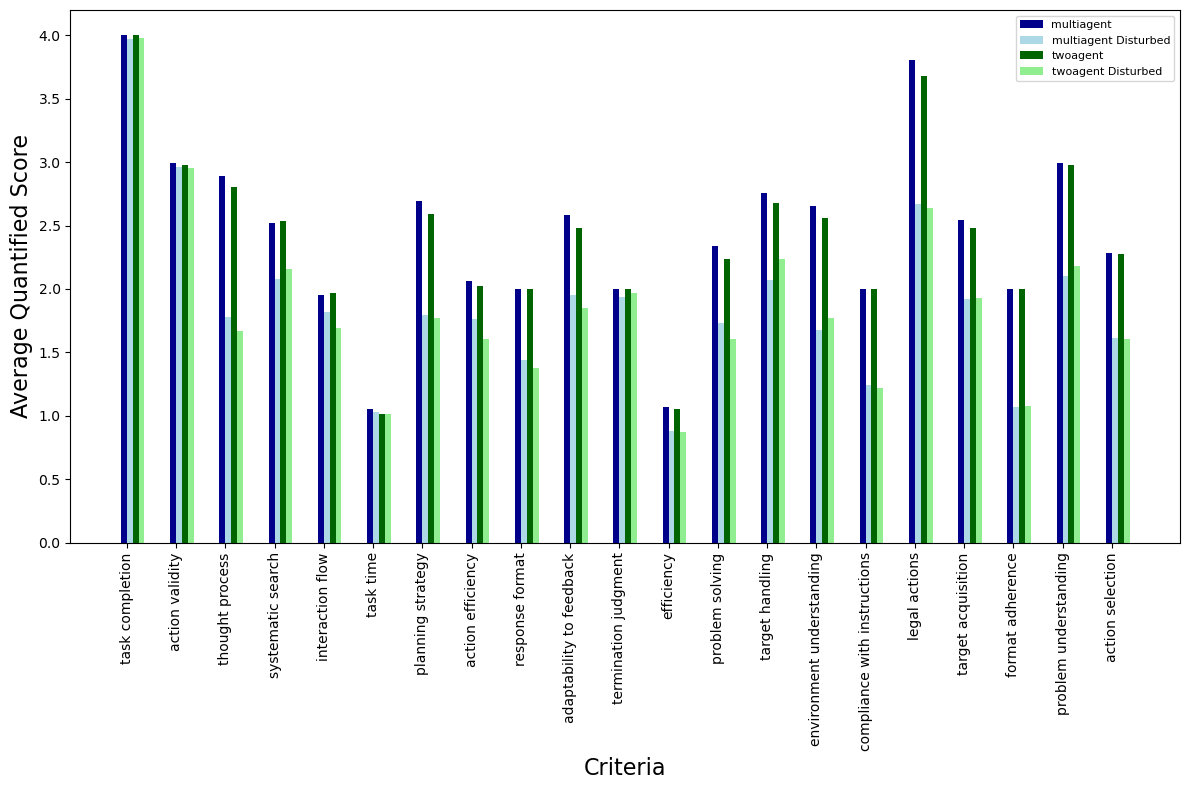

In [17]:
plot_quantifier_adversarial_testing()